In [1]:
import pandas as pd
import numpy as np

In [2]:
## !pip install pyarrow

In [2]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')

In [3]:
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

1. Column Count

In [4]:
df.shape

(3066766, 19)

In [5]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

2. Standard Deviation for duration column

In [6]:
df['duration'].std()

9.939385620145579

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='duration'>

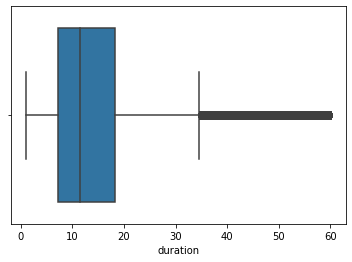

In [7]:
sns.boxplot(df['duration'])

3. Outlier Removal and its fraction

In [8]:
#Remove outliers

q = df["duration"].quantile(0.99)
df[df["duration"] < q]

q_low = df["duration"].quantile(0.01)
q_hi  = df["duration"].quantile(0.99)

df_filtered = df[(df["duration"] < q_hi) & (df["duration"] > q_low)]

In [9]:
x = (df.shape[0] - df_filtered.shape[0])
x/df.shape[0]*100

2.0093560589570623

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [14]:
len(df_train), len(df_val)

(3009173, 2855951)

# Reduced the size of train and test data due to buffer size issue and hence the rmse value may vary

In [12]:
df_train = df_train.iloc[:10000] 
df_val = df_val.iloc[:10000] 

In [13]:
len(df_train), len(df_val)

(10000, 10000)

4. One Hot Encoding

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [16]:
dv = DictVectorizer()

In [17]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

In [18]:
X_train.shape

(10000, 3022)

In [19]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [20]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

5. Training the model

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

6. Evaluating the model

In [24]:
y_pred = lr.predict(X_val)

rmse_val = mean_squared_error(y_val, y_pred, squared=False)
rmse_val

7.300704107930882